In [1]:
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u

import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

from Make_Data_Tools import slide, remove_nan
from Astronomy import *
from cut_resize_tools import process_data_segment

In [2]:
fits_path = "/home/filament/fujimoto/fits/Cygnus_sp16_vs-40_ve040_dv0.25_12CO_Tmb.fits"
integ_hdu = fits.open("/home/filament/fujimoto/fits/CygnusX_sp16_120-230_integrate_map.fits")[0]

w_high = WCS(fits_path)
hdu = fits.open(fits_path)[0]
wcs = WCS(integ_hdu.header)

raw_d = hdu.data
header = hdu.header

Changed DATE-OBS from '2016-01-13        ' to '2016-01-13T00:00:00.0''. [astropy.wcs.wcs]


In [3]:
vsmooth = 5
thresh = 1
sigma = 2
sch_rms = 10
ech_rms = 90
sch_ii = 121
ech_ii = 241
percentile = 99.997
sigma_multiply = 15

cut_size_list = [256, 128, 64]
integrate_layer_num = 30
obj_size = 100
maximum_mode = "percentile"
integrate_layer_num = 30

In [4]:
catalogue_path = 'cygnus_infer_catalogue.csv' # 提供されたCSVファイル
catalogue_data = pd.read_csv(catalogue_path)

In [5]:
babble_region_galactic = [] # 変換後の銀河座標を格納するリスト
for index, row in catalogue_data.iterrows():
    RA_min = row['ra_min'] * u.deg # 度単位でUnitsオブジェクトを作成
    RA_max = row['ra_max'] * u.deg
    DEC_min = row['dec_min'] * u.deg
    DEC_max = row['dec_max'] * u.deg

    # 各角の赤経・赤緯座標をSkyCoordオブジェクトとして定義
    # そして銀河座標系に変換
    # RA_min, DEC_min の点
    coord_min_min = SkyCoord(ra=RA_min, dec=DEC_min, frame='icrs').galactic
    # RA_max, DEC_min の点
    coord_max_min = SkyCoord(ra=RA_max, dec=DEC_min, frame='icrs').galactic
    # RA_min, DEC_max の点
    coord_min_max = SkyCoord(ra=RA_min, dec=DEC_max, frame='icrs').galactic
    # RA_max, DEC_max の点
    coord_max_max = SkyCoord(ra=RA_max, dec=DEC_max, frame='icrs').galactic

    # 変換された銀河座標 (l, b) のリストを作成
    babble_region_galactic.append([
        [coord_min_min.l.deg, coord_min_min.b.deg], # 0: L_min, B_min
        [coord_max_min.l.deg, coord_max_min.b.deg], # 1: L_max, B_min
        [coord_min_max.l.deg, coord_min_max.b.deg], # 2: L_min, B_max
        [coord_max_max.l.deg, coord_max_max.b.deg]  # 3: L_max, B_max
    ])
print(f"babble_region_galactic len: {len(babble_region_galactic)}")


# --- babble_region_pix への変換 (修正) ---
# ループ元を babble_region_galactic に変更
babble_region_pix = []
for i in range(len(babble_region_galactic)):
    babble_region = babble_region_galactic[i] # 銀河座標のバブル領域
    region_list = []
    for j in range(len(babble_region)):
        world_coords_list = [list(babble_region[j])] # [L, B] のリスト
        
        # WCS変換。世界座標 (L, B) をピクセル座標に変換
        # origin=0 でPythonの0-based indexに対応
        region_pix_result = wcs.wcs_world2pix(world_coords_list, 0)

        # 変換結果の形状と要素数をチェックする
        if len(region_pix_result) > 0 and len(region_pix_result[0]) == 2:
            region_list.append(region_pix_result[0]) # 期待通り [x, y] を追加
        else:
            print(f"警告: bubble_num={i}, point_idx={j} のWCS変換結果が不正です: {region_pix_result}. NaNで埋めます。")
            region_list.append([np.nan, np.nan]) # NaNで埋めて、後で除外されるようにする

    babble_region_pix.append(region_list)
print(f"babble_region_pix len: {len(babble_region_pix)}")

babble_region_galactic len: 78
babble_region_pix len: 78


In [6]:
cutting_ratio = 2
cutting_data_dic = {}
data_to_cut = raw_d.copy() # raw_d からのコピー

for bubble_num in range(len(babble_region_pix)):
    all_x_coords = [p[0] for p in babble_region_pix[bubble_num]]
    all_y_coords = [p[1] for p in babble_region_pix[bubble_num]]

    # ピクセル座標の最小値と最大値を取得
    # np.min と np.max を使うことで、座標の順序に関わらず正しい矩形領域の境界を取得
    # これにより、x_max_pix < x_min_pix のような逆転を防ぎ、スライス範囲が巨大になるのを防ぐ
    x_min_pix = int(np.floor(np.min(all_x_coords)))
    x_max_pix = int(np.ceil(np.max(all_x_coords)))
    y_min_pix = int(np.floor(np.min(all_y_coords)))
    y_max_pix = int(np.ceil(np.max(all_y_coords)))

    x_center = (x_min_pix + x_max_pix) // 2 
    y_center = (y_min_pix + y_max_pix) // 2
    
    x_range = (x_max_pix - x_min_pix) // 2 * cutting_ratio
    y_range = (y_max_pix - y_min_pix) // 2 * cutting_ratio

    x_min_pix = int(x_center - x_range)
    x_max_pix = int(x_center + x_range)
    y_min_pix = int(y_center - y_range)
    y_max_pix = int(y_center + y_range)

    # 切り出し実行
    # ここでは、np.clip を使用せず、NumPyのスライスが範囲外を0で自動パディングする動作に任せる
    # ただし、x_min_pix/y_min_pix が負になったり、x_max_pix/y_max_pix が大きくなりすぎたりすると、
    # 巨大な配列が生成される可能性がある点に注意（メモリ消費、処理時間）
    cutting_data = data_to_cut[:, y_min_pix:y_max_pix, x_min_pix:x_max_pix]
    pix_cood = (x_min_pix, x_max_pix, y_min_pix, y_max_pix)
    cutting_data_dic[pix_cood] = cutting_data

    # デバッグ用に切り出したデータの形状と範囲を表示してみる
    # print(f"Bubble {bubble_num}: X range [{x_min_pix}, {x_max_pix}], Y range [{y_min_pix}, {y_max_pix}], Shape: {cutting_data.shape}")

In [7]:
deleted_indices = []
filtered_list = [
    data for idx, data in enumerate(cutting_data_dic.items()) 
    if not np.all((data[1] == 0) | np.isnan(data[1]))
    or deleted_indices.append(idx)  # 削除されたインデックスを記録
]

# 削除されたインデックスを表示
print("削除されたデータのインデックス:", deleted_indices)
print("削除された数: ", len(deleted_indices))
print("残ったデータ数: ",len(filtered_list))

削除されたデータのインデックス: [4, 6, 8, 10, 11, 12, 19, 22, 24, 26, 27, 31, 33, 34, 36, 37, 38, 39, 42, 44, 45, 46, 50, 51, 53, 54, 55, 57, 59, 60, 61, 63, 64, 65, 68, 71, 73]
削除された数:  37
残ったデータ数:  41


In [8]:
remove_list = [0, 5, 8, 9, 10, 12, 17, 19, 21, 34]
filtered_list = [data for i, data in enumerate(filtered_list) if i not in remove_list]

In [9]:
all_map = raw_d.copy()

In [10]:
all_map = process_data_segment(all_map, vsmooth, sch_rms, ech_rms, sch_ii, ech_ii, sigma, thresh, integrate_layer_num)

/usr/local/lib/python3.8/dist-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Changed DATE-OBS from '2016-01-13        ' to '2016-01-13T00:00:00.0''. [astropy.wcs.wcs]


INFO: Auto-setting vmin to -1.501e+01 [aplpy.core]
INFO: Auto-setting vmax to  1.666e+02 [aplpy.core]


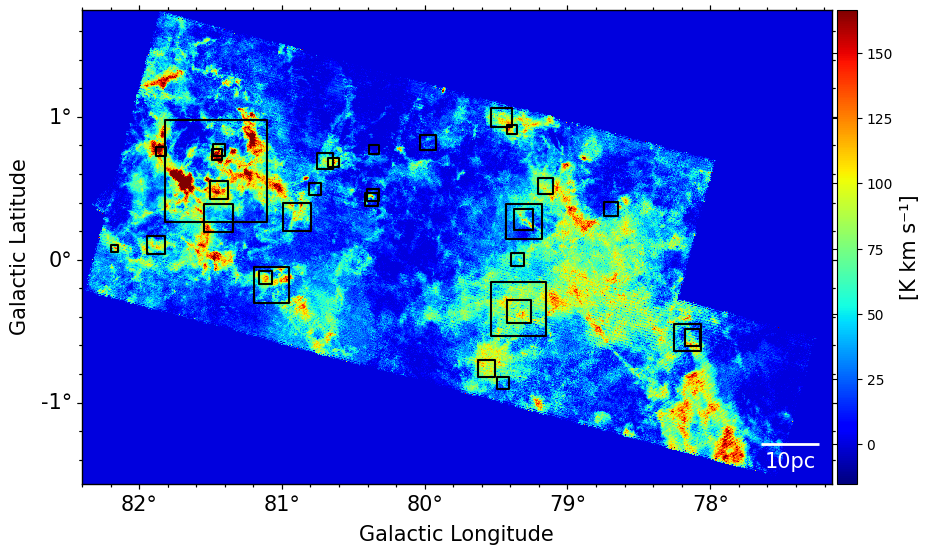

In [19]:
new_data = np.nansum(all_map, axis=0) * np.abs(header["CDELT3"]) / 1000.0
header2 = del_header_key(header, ["CRVAL3", "CRPIX3", "CRVAL3", "CDELT3", "CUNIT3", "CTYPE3", "CROTA3", "NAXIS3", "PC1_3", "PC2_3", "PC3_3", "PC3_1", "PC3_2"])
header2["NAXIS"] = 2
new_hdu = fits.PrimaryHDU(new_data, header2)

# --- 2. 描画 ---

# スケール計算
gc_distance = 1400
scale_per_pc = np.rad2deg(np.arcsin(1/gc_distance))

# FITSFigureオブジェクトの作成
fig = aplpy.FITSFigure(new_hdu)

# カラーマップ等の設定
fig.show_colorscale(cmap="jet", stretch='linear')
fig.set_nan_color("w") # NaN値は白に設定
fig.add_colorbar()
fig.colorbar.set_location('right')
fig.colorbar.set_axis_label_text("[K km s⁻¹]")
fig.colorbar.set_axis_label_font(size=15)
fig.tick_labels.set_font(size=15)
fig.ticks.set_color("black")
fig.axis_labels.set_font(size=15)

# スケールバーの追加
fig.add_scalebar(scale_per_pc*10)
fig.scalebar.set_label('10pc')
fig.scalebar.set_color('w')
fig.scalebar.set_linewidth(2)
fig.scalebar.set_font(size=15)

# --- 3. 四角形の重ね描き (ここが新しい部分) ---
# 描画する四角形の情報を格納するリストを準備
rect_xw, rect_yw, rect_w, rect_h = [], [], [], []

# ヘッダからピクセルあたりの角度を取得
cdelt1 = np.abs(header2['CDELT1'])
cdelt2 = np.abs(header2['CDELT2'])

for pdu in filtered_list:
    pdu = pdu[0]
    x_min, x_max, y_min, y_max = pdu[0], pdu[1], pdu[2], pdu[3]

    # 四角形の中心のピクセル座標を計算
    x_center_pix = (x_min + x_max) / 2.0
    y_center_pix = (y_min + y_max) / 2.0

    # 四角形の幅と高さをピクセル数から角度(度)に変換
    width_deg = (x_max - x_min) * cdelt1
    height_deg = (y_max - y_min) * cdelt2

    # 中心のピクセル座標を世界座標(経度、緯度)に変換
    lon_center, lat_center = fig.pixel2world(x_center_pix, y_center_pix)

    # リストに情報を追加
    rect_xw.append(lon_center)
    rect_yw.append(lat_center)
    rect_w.append(width_deg)
    rect_h.append(height_deg)

# show_rectanglesで全ての四角形を一度に描画
fig.show_rectangles(rect_xw, rect_yw, rect_w, rect_h, edgecolor='k', facecolor='none', linewidth=1.5)

# 画像を保存
plt.savefig("Cygnus-X_bubble_overlay.png", dpi=1000)